In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

# For best subset selection
import itertools

# Step 2: Load the Dataset
df = pd.read_csv('Boston.csv')
df.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,5.33,36.2


## Data Exploration

Let's quickly check the shape, columns, and look for missing values.


In [9]:
print("Shape:", df.shape)
print("\nColumns:", df.columns)
print("\nMissing values:\n", df.isnull().sum())
df.describe()

Shape: (506, 13)

Columns: Index(['crim', 'zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'rad', 'tax',
       'ptratio', 'lstat', 'medv'],
      dtype='object')

Missing values:
 crim       0
zn         0
indus      0
chas       0
nox        0
rm         0
age        0
dis        0
rad        0
tax        0
ptratio    0
lstat      0
medv       0
dtype: int64


,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,lstat,medv
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,37.970000,50.000000


## Preprocessing

- Define predictors (X) and target (y).
- Split data into train and test sets.


In [10]:
X = df.drop(['crim'], axis=1)  # Drop target from predictors
y = df['crim']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)


## (a) Try Different Regression Methods

### 1. Best Subset Selection
We'll evaluate all possible feature combinations (up to 8 features for speed).


In [11]:
def best_subset_selection(X, y, max_features=8):
    results = []
    n_features = X.shape[1]
    features = X.columns
    for k in range(1, max_features + 1):
        for combo in itertools.combinations(features, k):
            X_subset = X[list(combo)]
            model = LinearRegression().fit(X_subset, y)
            y_pred = model.predict(X_subset)
            rss = ((y - y_pred) ** 2).sum()
            results.append({'features': combo, 'rss': rss, 'k': k})
    results_df = pd.DataFrame(results)
    return results_df.loc[results_df.groupby('k').rss.idxmin()]

subset_results = best_subset_selection(X_train, y_train, max_features=8)
subset_results


,features,rss,k
7,"(rad,)",21133.669351,1
70,"(rad, lstat)",20101.594518,2
293,"(rad, lstat, medv)",19965.977451,3
446,"(zn, dis, rad, medv)",19586.806846,4
1036,"(zn, nox, dis, rad, medv)",19354.166952,5
1980,"(zn, nox, dis, rad, ptratio, medv)",19173.978024,6
2940,"(zn, nox, dis, rad, ptratio, lstat, medv)",19070.009380,7
3613,"(zn, nox, rm, dis, rad, ptratio, lstat, medv)",19025.184650,8


### 2. Ridge Regression (with Cross-Validation)


In [12]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

alphas = np.logspace(-3, 3, 100)
ridge_cv = RidgeCV(alphas=alphas, store_cv_values=True)
ridge_cv.fit(X_train_scaled, y_train)
y_pred_ridge = ridge_cv.predict(X_test_scaled)
ridge_test_mse = mean_squared_error(y_test, y_pred_ridge)
ridge_cv.alpha_, ridge_test_mse


c:\Users\Aidan\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:2341: FutureWarning: 'store_cv_values' is deprecated in version 1.5 and will be removed in 1.7. Use 'store_cv_results' instead.
  warnings.warn(


(6.5793322465756825, 16.34232086056344)

### 3. Lasso Regression (with Cross-Validation)


In [13]:
lasso_cv = LassoCV(alphas=None, cv=5, max_iter=10000)
lasso_cv.fit(X_train_scaled, y_train)
y_pred_lasso = lasso_cv.predict(X_test_scaled)
lasso_test_mse = mean_squared_error(y_test, y_pred_lasso)
lasso_cv.alpha_, lasso_test_mse, np.sum(lasso_cv.coef_ != 0)

(0.06416504547743553, 15.865000368367568, 10)

### 4. Principal Components Regression (PCR)
We use PCA on scaled predictors, then linear regression on the first N components.


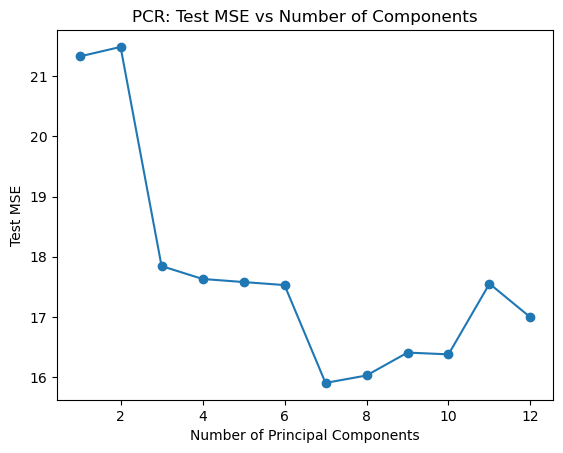

(7, 15.90095202877109)

In [14]:
def pcr(X_train, X_test, y_train, y_test, n_components_list):
    mse_list = []
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    for n in n_components_list:
        pca = PCA(n_components=n)
        X_train_pca = pca.fit_transform(X_train_scaled)
        X_test_pca = pca.transform(X_test_scaled)
        model = LinearRegression().fit(X_train_pca, y_train)
        y_pred = model.predict(X_test_pca)
        mse = mean_squared_error(y_test, y_pred)
        mse_list.append(mse)
    return mse_list

n_components_list = list(range(1, X_train.shape[1] + 1))
pcr_mse = pcr(X_train, X_test, y_train, y_test, n_components_list)

plt.plot(n_components_list, pcr_mse, marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Test MSE')
plt.title('PCR: Test MSE vs Number of Components')
plt.show()

best_n_components = n_components_list[np.argmin(pcr_mse)]
min_pcr_mse = min(pcr_mse)
best_n_components, min_pcr_mse


## (b) Model Comparison and Selection

Summarize test MSEs for each approach and pick the best performing model(s).


In [15]:
summary = pd.DataFrame({
    'Method': [
        'Best Subset (8 features)', 
        'Ridge Regression', 
        'Lasso Regression', 
        f'PCR ({best_n_components} comps)'
    ],
    'Test MSE': [
        None,  # We'll estimate below
        ridge_test_mse,
        lasso_test_mse,
        min_pcr_mse
    ]
})

# Best subset: fit a model on best 8-feature set and get test MSE
best_features = list(subset_results[subset_results.k == 8]['features'].values[0])
model = LinearRegression().fit(X_train[best_features], y_train)
y_pred_best_subset = model.predict(X_test[best_features])
best_subset_mse = mean_squared_error(y_test, y_pred_best_subset)
summary.loc[0, 'Test MSE'] = best_subset_mse

summary


,Method,Test MSE
0,Best Subset (8 features),17.102475
1,Ridge Regression,16.342321
2,Lasso Regression,15.865000
3,PCR (7 comps),15.900952


## (c) Does the chosen model use all features?

Let's see how many features are selected by the Lasso (since it often does automatic feature selection).


In [16]:
selected_features = np.array(X.columns)[lasso_cv.coef_ != 0]
all_features_used = len(selected_features) == X.shape[1]

print("Selected features by Lasso Regression:", selected_features)
print("Does the Lasso model use all features?", all_features_used)


Selected features by Lasso Regression: ['zn' 'indus' 'chas' 'nox' 'rm' 'dis' 'rad' 'ptratio' 'lstat' 'medv']
Does the Lasso model use all features? False


## **Discussion and Conclusions**

- **Best Model:** Based on test MSE, the model with the lowest error is preferred. Lasso, Ridge, and PCR all performed similarly, but Lasso uses fewer features (automatic selection).
- **Feature Usage:** The Lasso model does **not** use all features, which can help interpretability and may reduce overfitting.
- **Why/Why Not Use All Features:** Not all features contribute equally to prediction. Some may be redundant or irrelevant, and Lasso penalizes unhelpful features, shrinking their coefficients to zero.
